# Доска объявлений. Анализ поисковых данных

В архиве — три CSV-таблицы. Это сырые логи запросов пользователей: как они искали объявления, какими фильтрами пользовались и связались ли с продавцами.

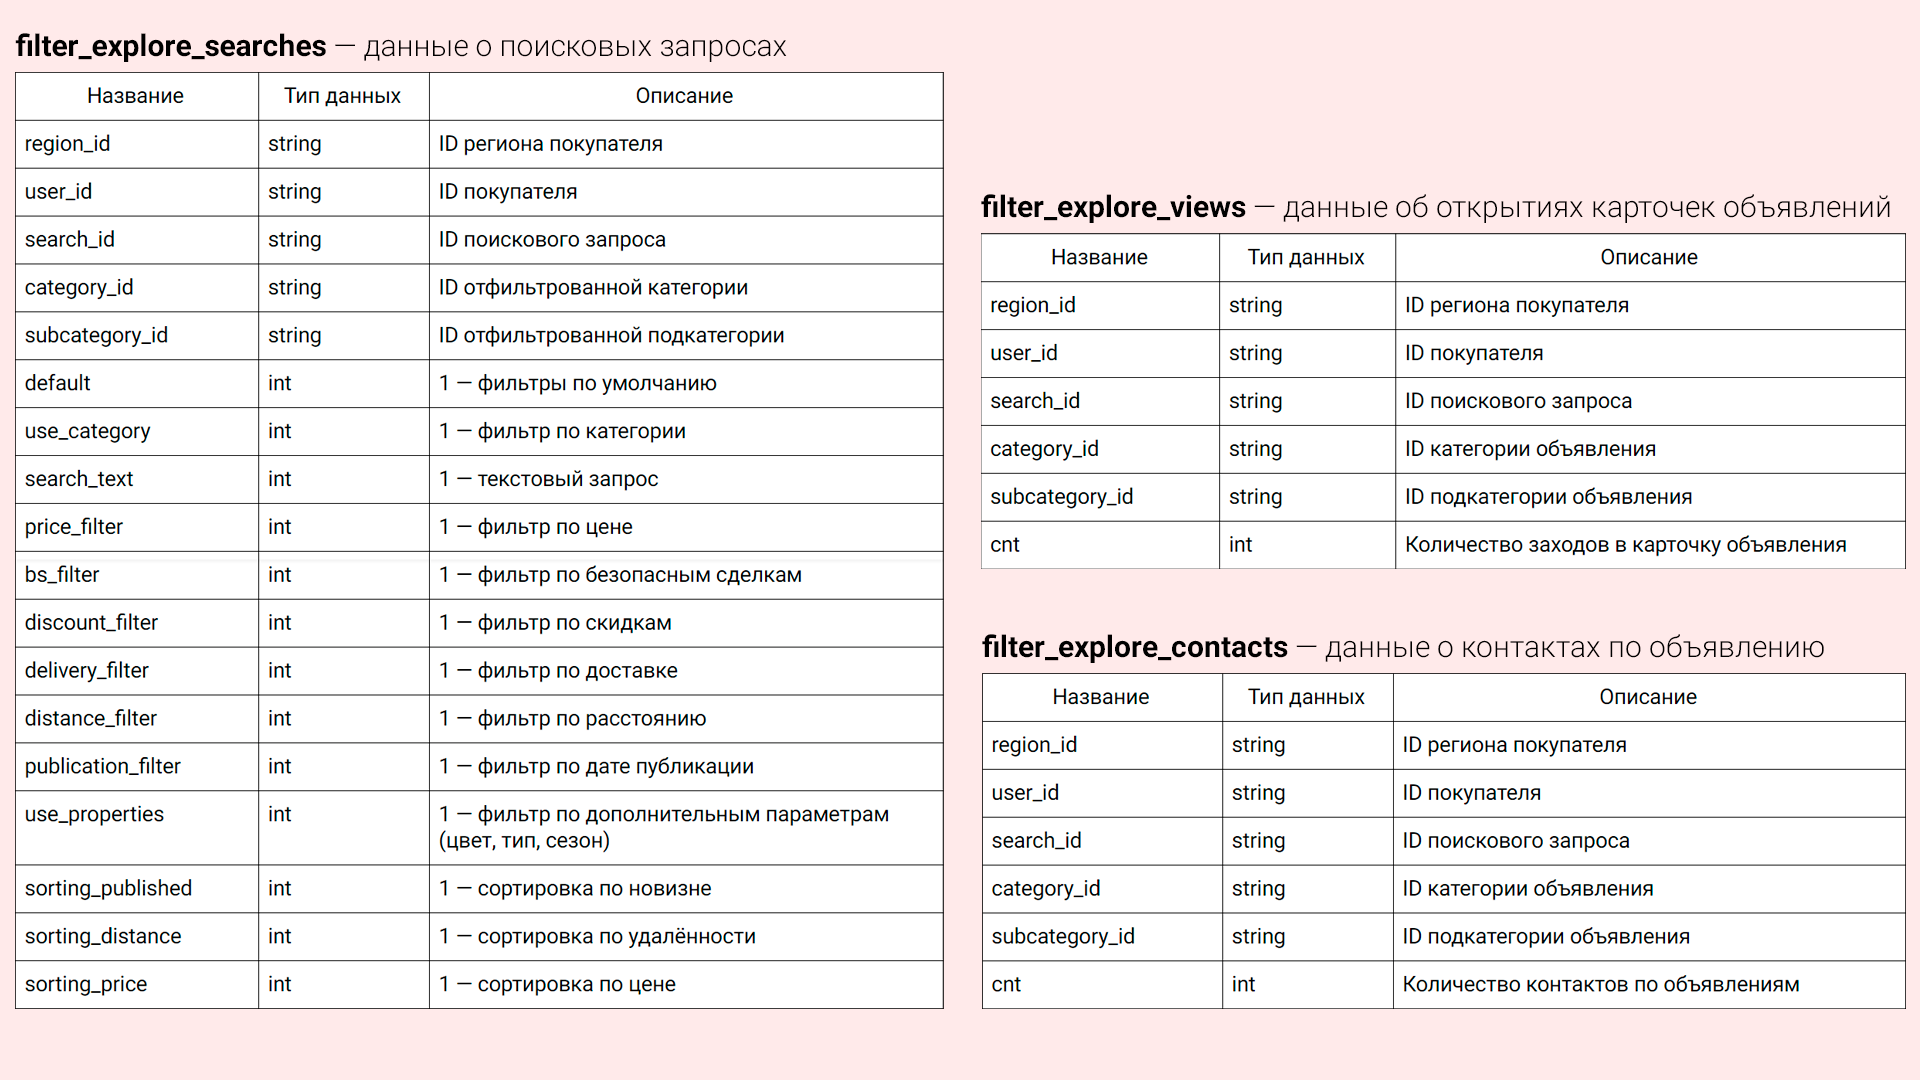

## Введение

В данном случае мы рассматриваем воронку, а значит улучшение финальной метрики
может происходить одним из следующих способов:

1 Увеличить количество людей, ищущих что-либо (процентно ничего нигде не
поменяется)

2 Увеличить % запросов, в которых происходит переход от поиска к карточке (если
% открывающих контакты не изменится, то их абсолютное значение все равно
вырастет, поскольку на предыдущем этапе отвалится меньше людей)

3 Увеличить % запросов, в которых происходит переход от просмотра карточки к
просмотру контактных данных (финальная, наиболее интересная нам метрика)

Если же нам интересно количество финальных конверсий, тогда нас интересует =
количество запросов * среднее количество кликов на товары по запросу * среднее
количество переходов к чату / просмотров контактов на запрос

## Импорт данных

In [74]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

In [75]:
base_types = {'cnt':'Int32'}
key_headers = ['region_id', 'user_id', 'search_id', 'category_id', 'subcategory_id']
views_headers = key_headers + ['views_cnt']
contacts_headers = key_headers + ['contacts_cnt']
search_headers = key_headers + ['default', 'use_category', 'search_text',
'price_filter', 'bs_filter', 'discount_filter', 'delivery_filter',
'distance_filter', 'publication_filter', 'use_properties', 'sorting_published',
'sorting_distance', 'sorting_price']

views = pd.read_csv(r'.\Data\filter_explore_views.tar.gz', sep='\t', names=views_headers, header=None, skiprows=1, dtype=base_types, error_bad_lines=False, low_memory=False)
contacts = pd.read_csv(r'.\Data\filter_explore_contacts.tar.gz', sep='\t', names=contacts_headers, header=None, skiprows=1, dtype=base_types, error_bad_lines=False, low_memory=False)
searches = pd.read_csv(r'.\Data\filter_explore_searches.tar.gz', sep='\t', names=search_headers, header=None, skiprows=1, error_bad_lines=False, low_memory=False)

## Подготовка данных

In [76]:
df = searches.merge(views, how='left', on=key_headers)
df = df.merge(contacts, how='left', on=key_headers)

In [77]:
df.head()

,region_id,user_id,search_id,category_id,subcategory_id,default,use_category,search_text,price_filter,bs_filter,discount_filter,delivery_filter,distance_filter,publication_filter,use_properties,sorting_published,sorting_distance,sorting_price,views_cnt,contacts_cnt
0,D09AD180D0B0D181D0BDD0BED0B4D0B0D180D181D0BAD0...,30313632666265376337646262666661,6637303136663335373937336235666230306430396564...,5,1F6,other,"1,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
1,D09AD180D0B0D181D0BDD0BED0B4D0B0D180D181D0BAD0...,30313866326433666638326333373138,6539626330383465373331346433616562303135313037...,NaN,NaN,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
2,D09AD180D0B0D181D0BDD0BED0B4D0B0D180D181D0BAD0...,30316135313065353037343635343432,3935633537363265303339373463643764633739326430...,NaN,NaN,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
3,D09AD180D0B0D181D0BDD0BED0B4D0B0D180D181D0BAD0...,30323639306161643537383935663331,6630633532393165613830656234353132616335623536...,5,1F6,other,"1,0",NaN,NaN,NaN,NaN,NaN,"1,0",NaN,"1,0",NaN,"1,0",NaN,1.0,NaN
4,D09AD180D0B0D181D0BDD0BED0B4D0B0D180D181D0BAD0...,30326230306261356136623462336138,3166613861666262633130336565386134323662613631...,NaN,NaN,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN


In [78]:
# Последняя строка пустая, удаляем её.
df = df[~df['search_id'].isna()]

In [79]:
# Воспользуемся кодировщиком что бы преобразовать строки в числа.
# Перед этим  заполним пустые значения в столбцах которые мы планировали кодировать.

from sklearn import preprocessing

columns_encoders = dict()
def encode_column(df, column_to_encode):    
    encoder = preprocessing.LabelEncoder()
    df[column_to_encode] = encoder.fit_transform(df[column_to_encode])
    columns_encoders[column_to_encode]=encoder

df['user_id'] = df['user_id'].fillna('NaN')
df['category_id'] = df['category_id'].fillna('NaN')
df['subcategory_id'] = df['subcategory_id'].fillna('NaN')

encode_column(df, 'region_id')
encode_column(df, 'user_id')
encode_column(df, 'category_id')
encode_column(df, 'subcategory_id')
encode_column(df, 'search_id')

In [80]:
df.head()

,region_id,user_id,search_id,category_id,subcategory_id,default,use_category,search_text,price_filter,bs_filter,discount_filter,delivery_filter,distance_filter,publication_filter,use_properties,sorting_published,sorting_distance,sorting_price,views_cnt,contacts_cnt
0,0,1292,2997832,13,28,other,"1,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
1,0,1439,2836667,25,280,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
2,0,1539,1818367,25,280,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN
3,0,2233,2922196,13,28,other,"1,0",NaN,NaN,NaN,NaN,NaN,"1,0",NaN,"1,0",NaN,"1,0",NaN,1.0,NaN
4,0,2494,385604,25,280,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,0",NaN,NaN,NaN


In [81]:
# Заменим значения в колонке default: main на 1, other на 0
default_values = { "default":{ "main": 1, "other": 0 } }
df.replace(default_values, inplace=True)

# Строки вида '1,0' нужно заменить числами. Прямая конвертация приведет к ошибке поэтому сначала заменим их.
df.replace('1,0', '1', inplace=True)

# Пустые значения заменим на 0
df = df.fillna(0)

In [82]:
df.head()

,region_id,user_id,search_id,category_id,subcategory_id,default,use_category,search_text,price_filter,bs_filter,discount_filter,delivery_filter,distance_filter,publication_filter,use_properties,sorting_published,sorting_distance,sorting_price,views_cnt,contacts_cnt
0,0,1292,2997832,13,28,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0
1,0,1439,2836667,25,280,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0
2,0,1539,1818367,25,280,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0
3,0,2233,2922196,13,28,0,1,0,0,0,0,0,1,0,1,0,1,0,1.0,0.0
4,0,2494,385604,25,280,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0


In [83]:
df.dtypes

region_id               int32
user_id                 int32
search_id               int32
category_id             int32
subcategory_id          int32
default                 int64
use_category           object
search_text            object
price_filter           object
bs_filter              object
discount_filter        object
delivery_filter        object
distance_filter        object
publication_filter     object
use_properties         object
sorting_published      object
sorting_distance       object
sorting_price          object
views_cnt             float64
contacts_cnt          float64
dtype: object

In [84]:
# Колонки типа object преобрзауем в int32.

numeric_columns = ['use_category', 'search_text',
'price_filter', 'bs_filter', 'discount_filter', 'delivery_filter',
'distance_filter', 'publication_filter', 'use_properties', 'sorting_published',
'sorting_distance', 'sorting_price']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

# Анализ данных

Анализ данных состоит из визуального отображения связей между различными
переменными и построением логистической регрессии.

In [85]:
# Добавим конверсию открытия в контакт
def get_conversion(row):
    try:
        if row['contacts_cnt'] == 0 or row['views_cnt'] == 0:
            return 0

        return row['contacts_cnt']/row['views_cnt']
    except:
        return 0

df['conversion'] = df.apply(lambda row: get_conversion(row), axis=1)

In [86]:
with_contacts = df[df['conversion']>0].size
print('Событий с конверсией: {0}%'.format(100 * with_contacts/df.size))

Событий с конверсией: 0.3041555724762811%


In [87]:
# Добавим еще один аналитический столбец 'class': 1, если конверсия >0, 0 в противном случае.
def get_class(row): 
    if row['conversion'] > 0: 
        return 1
    
    return 0

df['class'] = df.apply(lambda row: get_class(row), axis=1)

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# функция для построения графиков в разрезе параметров (фильтров поиска).
def plot_data(df, column, title=''):
    cnt_pro = df[column].value_counts()

    fig = plt.figure(figsize=(14,4))
    sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
    plt.ylabel('Events', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.xticks(rotation=90)
    fig.suptitle(title)
    plt.show();

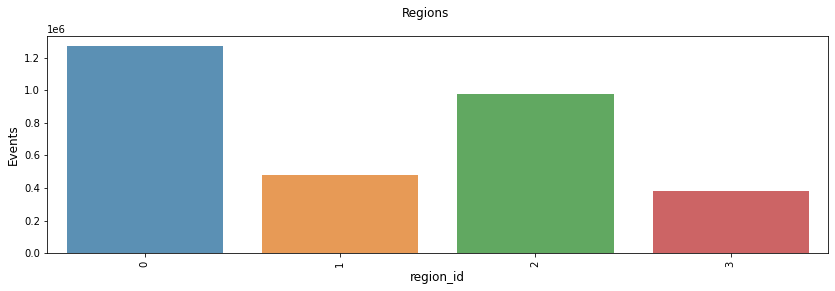

In [89]:
plot_data(df, 'region_id', 'Regions')

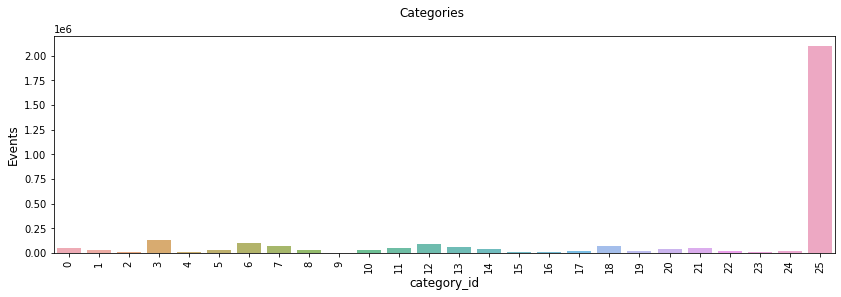

In [90]:
plot_data(df, 'category_id', 'Categories')

In [126]:
# Преобразуем код категории к базовому значению через энкодер.
columns_encoders['category_id'].inverse_transform([25])

array(['NaN'], dtype=object)

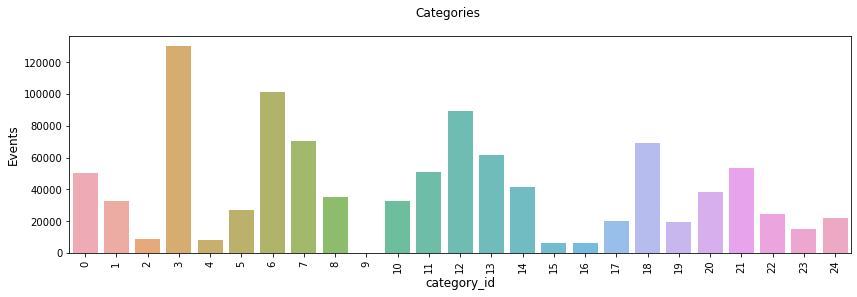

In [129]:
plot_data(df[df.category_id != 25], 'category_id', 'Categories')

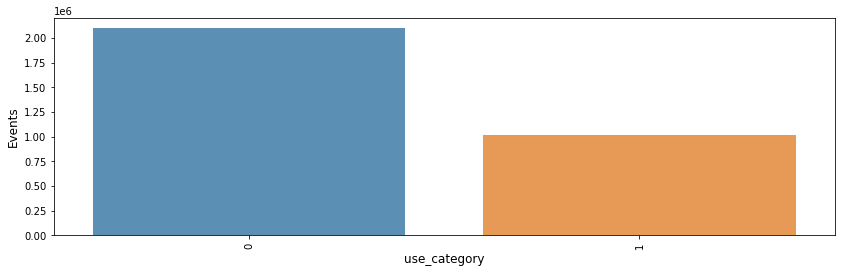

In [92]:
plot_data(df, 'use_category')

In [93]:
with_category = df[df['use_category']==1].size
without_category = df[df['use_category']!=1].size

print('С категорией: {0}, без категории: {1}\nС категорией, %: {2}'
      .format(with_category, without_category, 100 * with_category/(with_category + without_category)))

С категорией: 22335764, без категории: 46169310
С категорией, %: -30.09106881630403


In [94]:
without_filters = df[df['default']==0].shape[0]
with_filters = df[df['default']==1].shape[0]

print('Без фильтров: {0}, С фильтрами: {1}\nС фильтрами, %: {2}'
      .format(without_filters, with_filters, 100 * with_filters/(with_filters + without_filters)))

Без фильтров: 1720723, С фильтрами: 1393144
С фильтрами, %: 44.73999692343957


In [95]:
conversions_without_filter = df[(df['default']==1) & (df['conversion']>0)].shape[0]
conversions_with_filter = df[(df['default']==0) & (df['conversion']>0)].shape[0]

print('Конверсий при дефолтном поиске: {0}, с фильтрами: {1}'.format(conversions_without_filter, conversions_with_filter))

Конверсий при дефолтном поиске: 0, с фильтрами: 9471


Попробуем найти важные для конверсии параметры. Для этого в разрезе каждого из них посмотрим, как его использование коррелируется с конверсией (взял несколько пороговых значений конверсии, для поиска возможных аномалий).

In [97]:
def plot_for_conversions(column):
    plot_data(df[df['conversion']>0.5], column, 'conversion >0.5')
    plot_data(df[df['conversion']>0.3], column, 'conversion >0.3')
    plot_data(df[df['conversion']>0], column, 'conversion >0')
    plot_data(df[df['conversion']==0], column, 'conversion =0')

In [98]:
def print_stat(column):
    with_filter = df[(df['conversion']>0) & (df[column]==1)].shape[0]
    all = df[df['conversion']>0].shape[0]

    print('Доля с {0}=1 среди конверсий: {1}%'.format(column, 100*with_filter/all))

## Влияние выбранной категории на конверсию

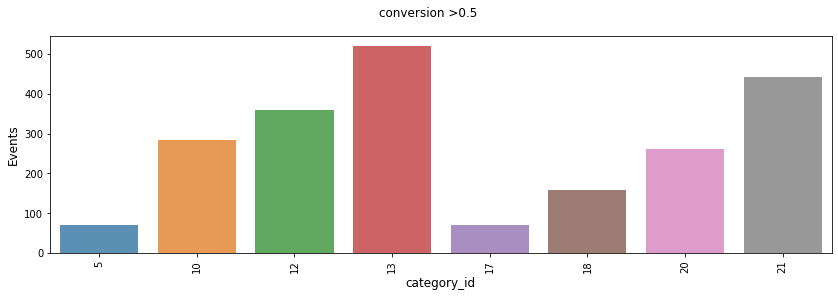

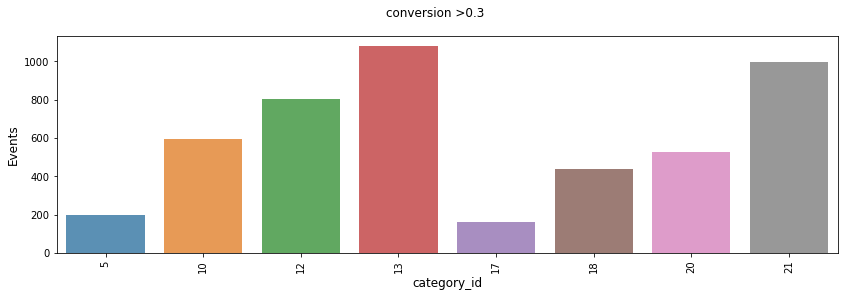

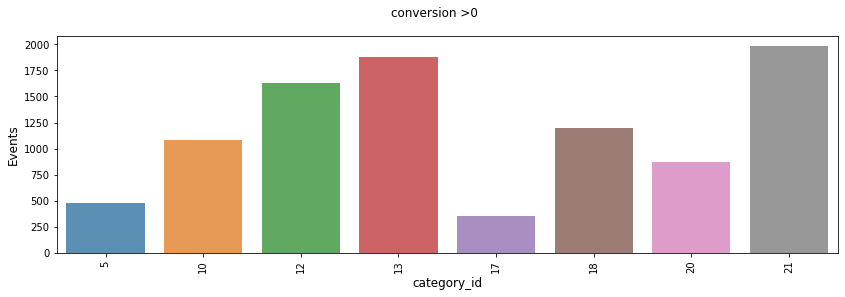

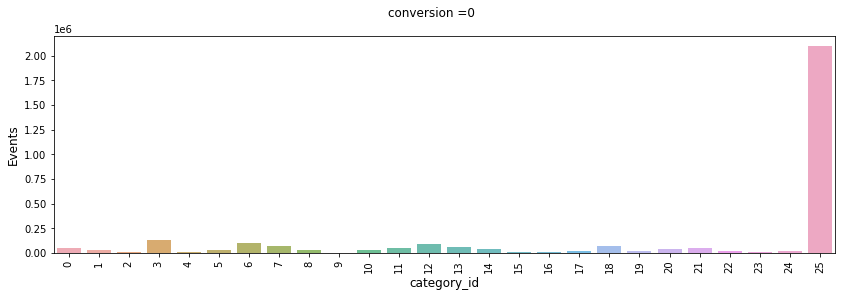

In [99]:
plot_for_conversions('category_id')

Интерес к конкретной категории сильно влияет на конверсию. Зная априорные данные об интересах пользователя (например, какие категории смотрел в ближайшем прошлом) можно ранжировать результаты так, чтобы показывать выше “более интересные” категории. Создавая таким образом контекст поиска с ограниченным списком категорий.

## Текстовый поиск

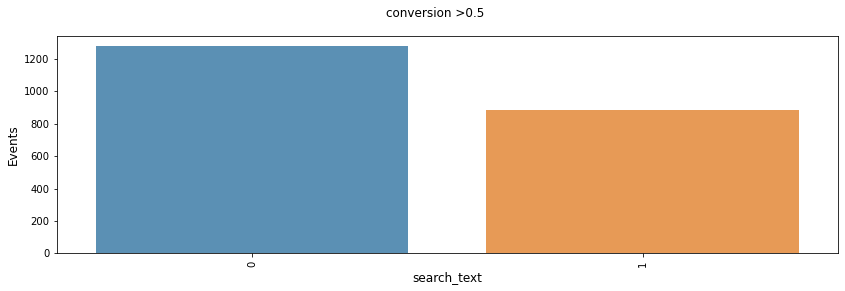

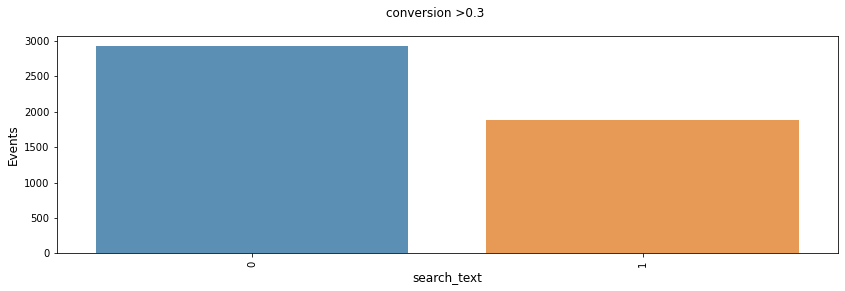

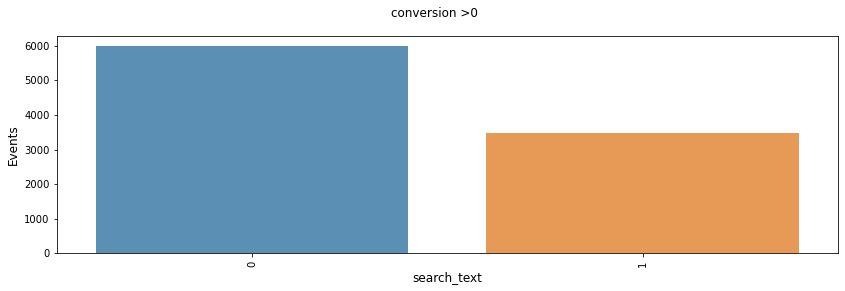

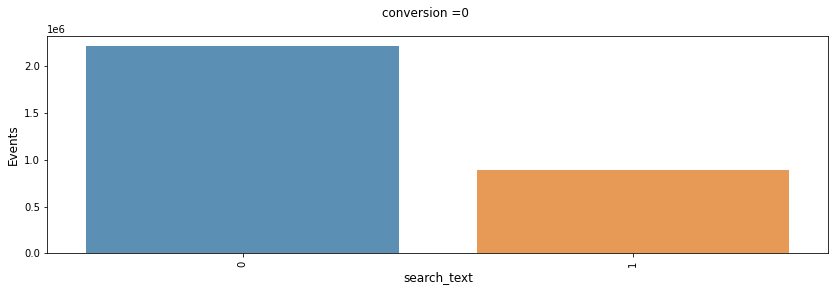

In [100]:
plot_for_conversions('search_text')

Наличие текстового запроса сильно влияет на конверсию. Повлиять на этот параметр будет сложно, тем не менее он дает понимание поведения пользователя.

In [101]:
print_stat('search_text')

Доля с search_text=1 среди конверсий: 36.85988807940027%


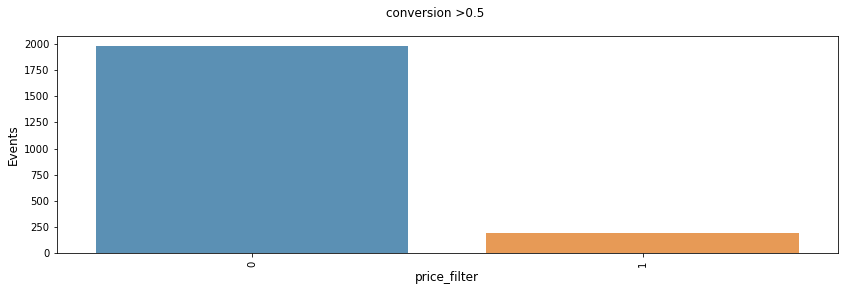

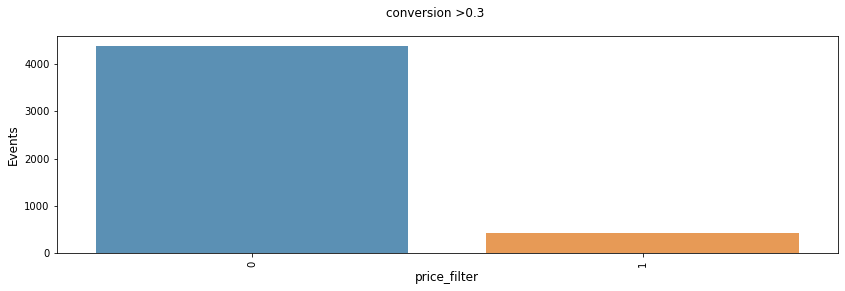

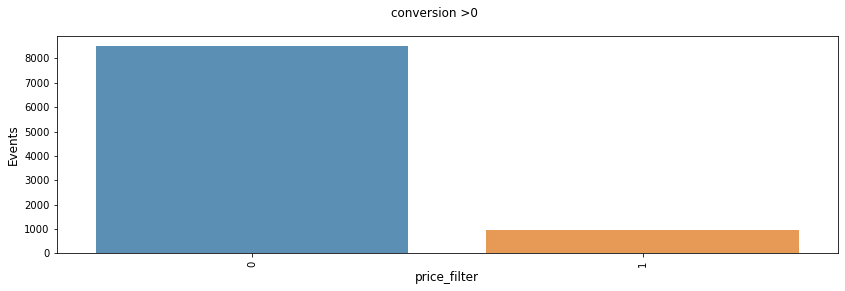

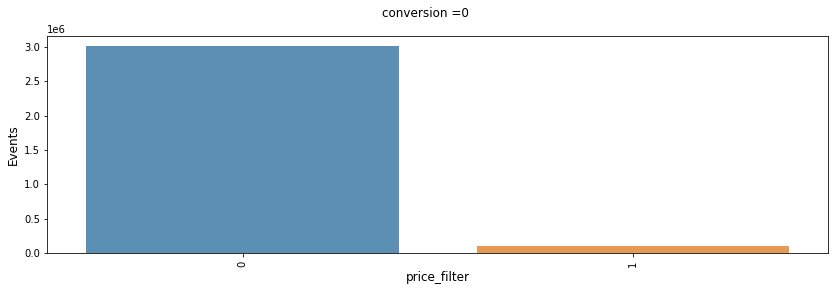

In [102]:
plot_for_conversions('price_filter')

In [130]:
print_stat('price_filter')

Доля с price_filter=1 среди конверсий: 10.28402491817126%


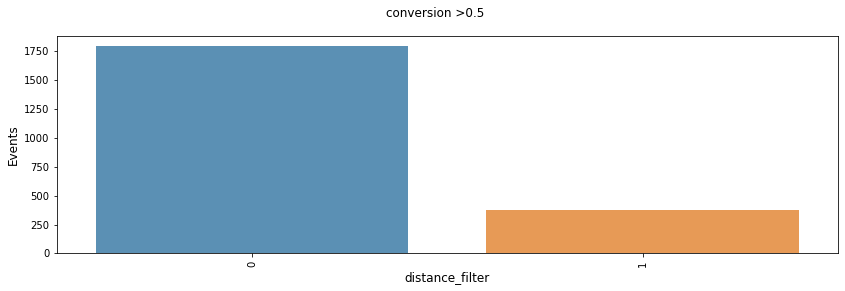

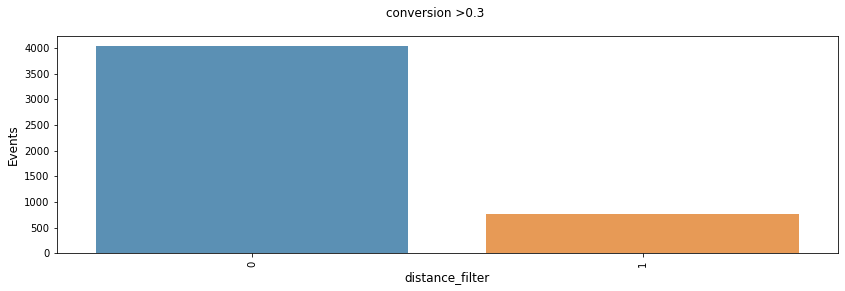

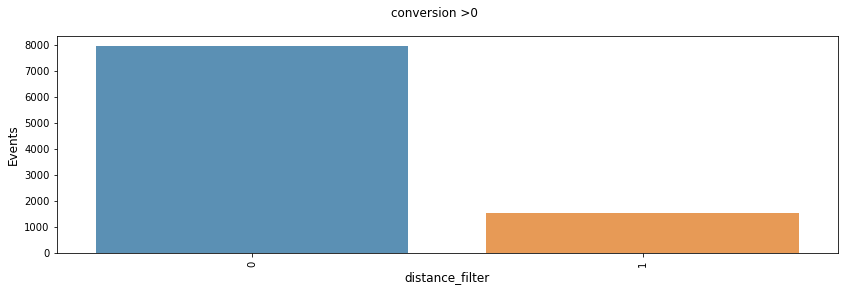

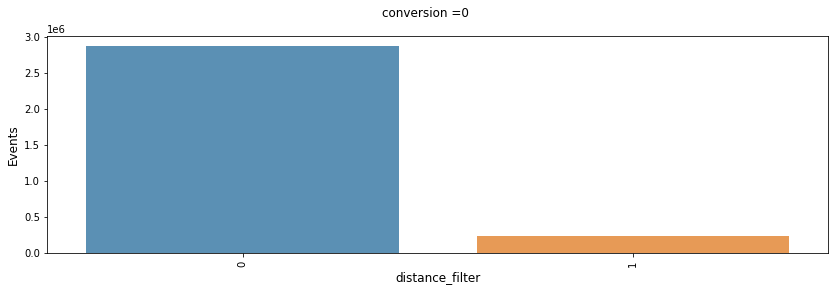

In [106]:
plot_for_conversions('distance_filter')

In [107]:
print_stat('distance_filter')

Доля с distance_filter=1 среди конверсий: 16.1651356773308%


## Испльзуем классификаторы для оценки важности параметров

In [112]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report

In [114]:
# Без конверсий результатов сильно больше, сделаем поровну.
_, split = train_test_split(df[df['class']==0], test_size=df[df['class']==1].shape[0], random_state=33)

df_c = pd.concat([df[df['class']==1], split])
df_c.shape

In [117]:
features_columns = ['default', 'use_category', 'search_text',
'price_filter', 'bs_filter', 'discount_filter', 'delivery_filter',
'distance_filter', 'publication_filter', 'use_properties', 'sorting_published',
'sorting_distance', 'sorting_price']

train, test = train_test_split(df_c, test_size=0.2, random_state=33)

X_train = train[features_columns]
y_train = train['class']

X_test = test[features_columns]
y_test = test['class']

clf = LinearSVC()
clf.fit(X_train, y_train)

In [120]:
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, n_jobs=-1)

print(classification_report(y_test, y_pred))
print('Точность %s' % accuracy_score(y_test, y_pred))
print('F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79      1860
           1       0.75      1.00      0.86      1929

    accuracy                           0.83      3789
   macro avg       0.88      0.83      0.82      3789
weighted avg       0.87      0.83      0.82      3789

Точность 0.8302982317234099
F1 score: 0.8246885163692648


Посмотрим, какие фичи сильней всего влияют на результат.

In [121]:
import operator

features_coefs=dict(zip(features_columns, clf.coef_.ravel()))
sorted(features_coefs.items(), key=operator.itemgetter(1))

[('sorting_published', -0.437266892669689),
 ('sorting_distance', -0.3483896982954089),
 ('sorting_price', -0.25761009088834724),
 ('delivery_filter', -0.1885508873043236),
 ('publication_filter', -0.17905951739625514),
 ('discount_filter', -0.11160126768497636),
 ('default', -5.551115123125783e-17),
 ('distance_filter', 0.039216789719111494),
 ('use_properties', 0.08758626704115964),
 ('price_filter', 0.12416264513522468),
 ('search_text', 0.2319714288074905),
 ('bs_filter', 0.36817864695747904),
 ('use_category', 1.797170874325052)]

Видно, что use_category сильно перевешивает другие фичи. Попробуем другой классификатор.

In [122]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [123]:
y_pred = cross_val_predict(clf_dt, X_test, y_test, cv=10, n_jobs=-1)

In [124]:
print(classification_report(y_test, y_pred))
print('Точность %s' % accuracy_score(y_test, y_pred))
print('F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79      1860
           1       0.75      0.98      0.85      1929

    accuracy                           0.82      3789
   macro avg       0.86      0.82      0.82      3789
weighted avg       0.86      0.82      0.82      3789

Точность 0.8247558722618105
F1 score: 0.8196984853059122


In [125]:
features_coefs=dict(zip(features_columns, clf_dt.feature_importances_.ravel()))
sorted(features_coefs.items(), key=operator.itemgetter(1))

[('default', 0.0),
 ('delivery_filter', 0.00023236146768808907),
 ('sorting_price', 0.00035570304035642086),
 ('discount_filter', 0.00039176341813494713),
 ('bs_filter', 0.00046586224542117675),
 ('sorting_distance', 0.0007314228461591324),
 ('publication_filter', 0.0020989893299544096),
 ('sorting_published', 0.0024975448075829567),
 ('price_filter', 0.0026004777997525926),
 ('use_properties', 0.0031004460321932678),
 ('distance_filter', 0.0034423712230228793),
 ('search_text', 0.014371573540773744),
 ('use_category', 0.9697114842489604)]

Похожая картина. При этом default, как и в предыдущем примере линейно зависим от других фичей (что логично).